# California Housing EDA and Modeling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [3]:
# KFold, cross_val_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
# Ridge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
from pathlib import Path
DATA_PATH = Path("data/housing.csv")
df = pd.read_csv(DATA_PATH)
df.describe()
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

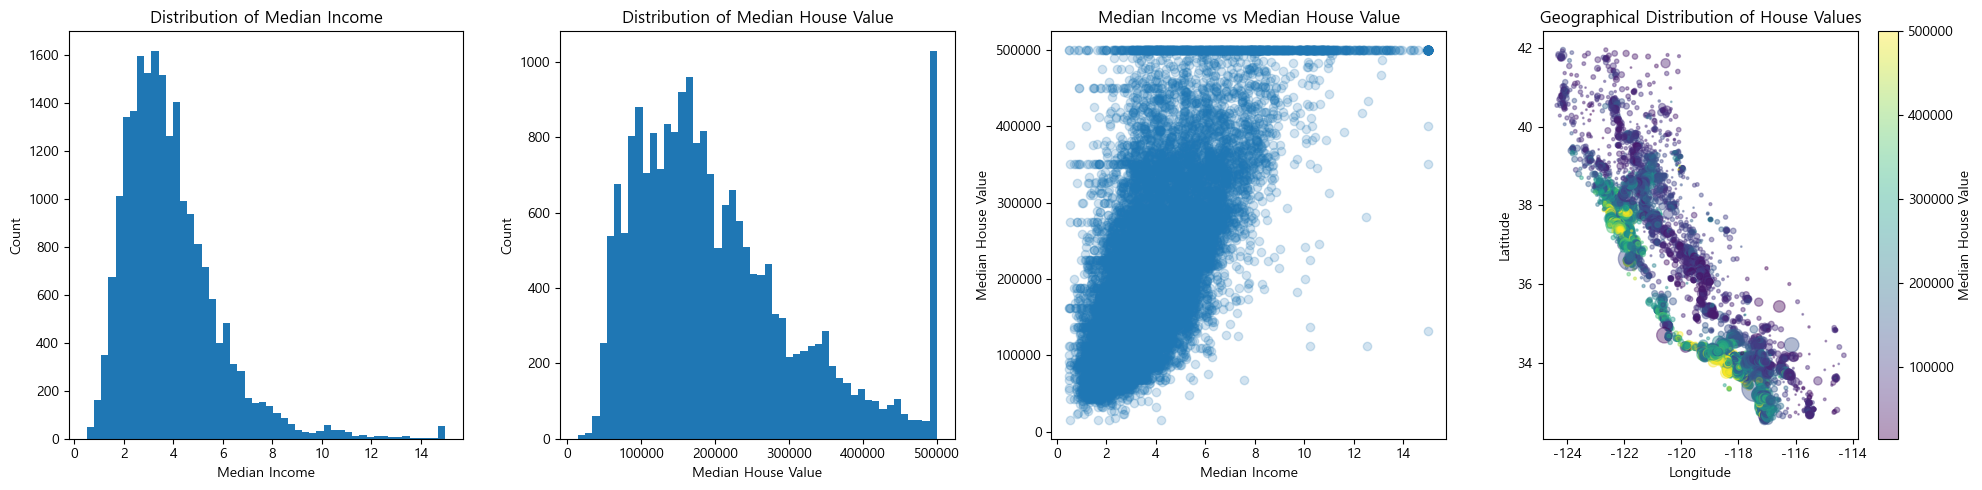

In [5]:
corr = df.corr(numeric_only=True)
target_corr = corr["median_house_value"].sort_values(ascending=False)

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

## 중위 소득 분포
axes[0].hist(df["median_income"], bins=50)
axes[0].set_title("Distribution of Median Income")
axes[0].set_xlabel("Median Income")
axes[0].set_ylabel("Count")

## 중위 주택 가치 분포
axes[1].hist(df["median_house_value"], bins=50)
axes[1].set_title("Distribution of Median House Value")
axes[1].set_xlabel("Median House Value")
axes[1].set_ylabel("Count")

## 중위 소득 vs 중위 주택 가치
axes[2].scatter(df["median_income"], df["median_house_value"], alpha=0.2)
axes[2].set_title("Median Income vs Median House Value")
axes[2].set_xlabel("Median Income")
axes[2].set_ylabel("Median House Value")

## 지리적 분포 (주택 가치)
sc = axes[3].scatter(df["longitude"], df["latitude"], c=df["median_house_value"],
                     s=(df["population"]/100).clip(lower=1), alpha=0.4)
axes[3].set_title("Geographical Distribution of House Values")
axes[3].set_xlabel("Longitude")
axes[3].set_ylabel("Latitude")

# 컬러바 추가
cbar = plt.colorbar(sc, ax=axes[3])
cbar.set_label("Median House Value")

plt.tight_layout()
plt.show()

In [6]:
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

num_features = X.select_dtypes(include=["float64", "int64", "float32", "int32"]).columns.tolist()
cat_features = ["ocean_proximity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
imputer = SimpleImputer(strategy="median")
X_train_num = imputer.fit_transform(X_train[num_features])
X_test_num = imputer.transform(X_test[num_features])

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

encoder = OneHotEncoder(handle_unknown="ignore")
X_train_cat = encoder.fit_transform(X_train[cat_features]).toarray()
X_test_cat = encoder.transform(X_test[cat_features]).toarray()

X_train_processed = np.hstack([X_train_num_scaled, X_train_cat])
X_test_processed = np.hstack([X_test_num_scaled, X_test_cat])

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# cross_val_score(logreg, ifis.data, iris.target, cv=kfold)
# list => for 
def cross_validate_model(model, X, y, cv=cv):
    rmse_scores=[]
    r2_scores=[]
    for train_idx, val_idx in cv.split(X):
        X_cv_train, X_cv_val = X[train_idx], X[val_idx]
        y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)

        rmse = np.sqrt(mean_squared_error(y_cv_val, y_pred))
        r2 = r2_score(y_cv_val, y_pred)

        rmse_scores.append(rmse)
        r2_scores.append(r2)

    return np.array(rmse_scores), np.array(r2_scores)

In [9]:
results = []

def evaluate_model(name, model, y_true, y_pred):
    rmse_score, r2_score = cross_validate_model(model, y_true,y_pred)
    
    print(f"{name}:")
                          # 배열로 출력되서 => .mean값    
    print(f"-- R^2 Score: {r2_score.mean():.4f} (+/- {r2_score.std()*2:.2f})")
    print(f"-- RMSE: {rmse_score.mean():.2f} (+/- {rmse_score.std()*2:.2f})")
    return {"model": name, "r2": r2_score, "rmse": rmse_score}

In [10]:
models = {
    "Linear Regression" : LinearRegression(),
    "Ridge" : Ridge(random_state=42, max_iter=5000),
    "Random Forest" : RandomForestRegressor(random_state=42)
}

cv_results = []
for name, model in models.items():
    result = evaluate_model(name, model, X_train_processed, y_train)
    cv_results.append(result)
cv_results


Linear Regression:
-- R^2 Score: 0.6477 (+/- 0.03)
-- RMSE: 68604.16 (+/- 2649.89)
Ridge:
-- R^2 Score: 0.6478 (+/- 0.03)
-- RMSE: 68595.60 (+/- 2632.15)
Random Forest:
-- R^2 Score: 0.8172 (+/- 0.01)
-- RMSE: 49424.12 (+/- 2463.17)


[{'model': 'Linear Regression',
  'r2': array([0.64701625, 0.65446226, 0.66872751, 0.63655587, 0.63161684]),
  'rmse': array([69793.50229311, 67748.61211153, 66466.60638207, 69972.41192577,
         69039.682064  ])},
 {'model': 'Ridge',
  'r2': array([0.64767631, 0.65445755, 0.66872989, 0.63647595, 0.6314616 ]),
  'rmse': array([69728.21615671, 67749.07425155, 66466.36731856, 69980.10498516,
         69054.22662316])},
 {'model': 'Random Forest',
  'r2': array([0.80837417, 0.82291065, 0.81847354, 0.81387536, 0.82252237]),
  'rmse': array([51423.85818198, 48500.79714988, 49201.77752807, 50073.73137867,
         47920.43061308])}]

In [11]:
#그리드서치: 평가를 기반으로 최적의 매개변수로 찾음
#랜덤포레스트 매개변수이름 같아야함 => 다르면 오류남
rf_param_grid = {
    "n_estimators" : [50, 100, 200],
    "max_depth" : [5,10, None],
    "min_samples_split" : [2,5,10]
}
                                          #intel에만돌아감/ cpu 8개 다 사용(원래는 1개 사용)->속도高 
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
             rf_param_grid,
             cv=cv,
             scoring="neg_mean_squared_error",
             n_jobs=-1)
rf_grid.fit(X_train_processed, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [18]:
print(rf_grid.best_params_)
print(-rf_grid.best_score_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
2427901712.393647


In [20]:
#랜덤 그리드 서치 => 그리드 서치보다 빠름 => 이거쓰세용
from scipy.stats import uniform, randint
rf_param_grid = {
    "n_estimators" : randint(50,300),
    "max_depth" : [5,10, 15, 20, None],
    "min_samples_split" : randint(2,10),
    "min_samples_leaf" : randint(1,10),
    "max_features" : ["sqrt", "log2", None]
}
          #RandomizedSearchCV
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
             rf_param_grid,
             cv=cv,
             scoring="neg_mean_squared_error",
             n_jobs=-1)
rf_grid.fit(X_train_processed, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C8ECE7A970>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C8EE037E50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C8EC1AD8B0>},
                   scoring='neg_mean_squared_error')

In [21]:
print(rf_random.best_params_)
print(rf_random.best_score_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [ ]:
result = evaluate_model("RandomizedSearchCV(RandomForest)",
                        rf_random.best_estimator_, 
                        X_train_processed, 
                        y_train)
result